# Exercise 2
for NLP lab SoSe18 by Nico Lutz

the task2 will focus on basic fact-checking. It will consist in training 3 different models to perform over 3 different datasets (technically 2 different datasets + 1 merged)

#### Env:
* python 3
* sklearn
* pandas

#### Resources:
* https://nlpforhackers.io/training-pos-tagger/
* https://opendatascience.com/how-to-build-a-fake-news-classification-model/
* [syncing the forked repo with the origin](https://github.com/desktop/desktop/issues/1785)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import itertools
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%pylab inline
from sklearn.metrics import precision_recall_fscore_support

Populating the interactive namespace from numpy and matplotlib


## Datasets

### [Dataset 1](https://github.com/GeorgeMcIntire/fake_real_news_dataset): Fake or Real news
only FAKE and REAL labels

In [2]:
df = pd.read_csv('./task2_datasets1_2/fake_or_real_news.csv')

In [3]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
print('Fake count:',df[df['label']=='FAKE'].size)
print('Real count:',df[df['label']=='REAL'].size)

Fake count: 12656
Real count: 12684


make train/test split balanced on the labels, so the labels are roughly represented equaly

### [Dataset 2](https://arxiv.org/pdf/1705.00648.pdf)
labels of a different range: pants-fire,barely-
true,  false, half-true, mostly-true, and true

In [5]:
path='./task2_datasets1_2/liar_liar_paints_on_fire/liar_dataset/'
headers=['id','label','statement','subject','speaker','speakerstitle','stateinfo','party','barely-true','false','half-true','mostly-true','pants-on-fire','context']
ds2_train_df = pd.read_csv(path+'train.tsv',sep='\t', names=headers)
ds2_test_df = pd.read_csv(path+'test.tsv',sep='\t', names=headers)
ds2_valid_df = pd.read_csv(path+'valid.tsv',sep='\t',names=headers)

In [6]:
ds2_test_df.head()

,id,label,statement,subject,speaker,speakerstitle,stateinfo,party,barely-true,false,half-true,mostly-true,pants-on-fire,context
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [7]:
ds2_test_df.label.value_counts()

half-true      265
false          249
mostly-true    241
barely-true    212
true           208
pants-fire      92
Name: label, dtype: int64

In [8]:
#split
lb = preprocessing.LabelBinarizer()
ds2_train = ds2_train_df['statement']
ds2_y_train = ds2_train_df['label']
ds2_y_train = lb.fit_transform(ds2_y_train)

ds2_test = ds2_test_df['statement']
ds2_y_test = ds2_test_df['label']
ds2_y_test = lb.fit_transform(ds2_y_test)

ds2_valid = ds2_valid_df['statement']
ds2_y_valid = ds2_valid_df['label']
ds2_y_valid = lb.fit_transform(ds2_y_valid)

### Dataset 3 - combination of 1 and 2
copy and paste of script_dataset3.py provided by diegoesteves

In [9]:
import random
import sys
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split

ds1 = './task2_datasets1_2/fake_or_real_news.csv'
ds2 = path+'train.tsv' #should I merge the test and val file ? yes I should !

def get_dataset3_split(dataset1_in, dataset2_in):
    try:
        print('processing datasets')
        print('ds1=', dataset1_in)
        print('ds2=', dataset2_in)

        print('-- fake news')
        df1 = pd.read_csv(dataset1_in, sep=',', usecols=['title','text','label'])
        df1['claim'] = df1[['title', 'text']].apply(lambda x: '. '.join(x), axis=1)
        del df1['title']
        del df1['text']
        df1.rename(index=str, columns={'label': 'y'}, inplace=True)
        print(df1.keys())
        print(len(df1[df1['y']=='REAL']))
        print(len(df1[df1['y']=='FAKE']))
        df1['y'] = np.where(df1['y'] == 'FAKE', 'false', 'true')
        print(len(df1))

        print('-- liar liar')
        df2 = pd.read_csv(dataset2_in, sep='\t', header=None, usecols=[1,2], names=['y', 'claim'])
        print(df2.keys())
        print(set(df2.y), len(df2))
        print(len(df2[df2['y'] == 'true']))
        print(len(df2[df2['y'] == 'false']))
        df2=df2[(df2['y'] == 'true') | (df2['y'] == 'false')]
        print(set(df2.y), len(df2))

        df3=pd.concat([df1, df2], ignore_index=True)

        print(df3['y'].value_counts())
        print('done')
        return train_test_split(df3['claim'], df3['y'], test_size=0.30, random_state=35)
    except Exception as e:
        print(e)

ds3_train, ds3_test, ds3_y_train, ds3_y_test = get_dataset3_split(ds1,ds2)
print(len(ds3_train))
print(len(ds3_test))
print(ds3_y_train.get_values()[1], ds3_train.get_values()[1])


/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


processing datasets
ds1= ./task2_datasets1_2/fake_or_real_news.csv
ds2= ./task2_datasets1_2/liar_liar_paints_on_fire/liar_dataset/train.tsv
-- fake news
Index(['y', 'claim'], dtype='object')
3171
3164
6335
-- liar liar
Index(['y', 'claim'], dtype='object')
{'mostly-true', 'pants-fire', 'true', 'half-true', 'barely-true', 'false'} 10240
1676
1995
{'true', 'false'} 3671
false    5159
true     4847
Name: y, dtype: int64
done
7004
3002
false The Battleship Debate. By Michael Shrimpton on October 30, 2016 Some Battleship Myths Busted 
The comments on last week’s column (Aberfan – Disaster Or Attack?) threw up some unexpected comments about battleships, and the causes of World War I. As you can tell, it was a wide-ranging discussion! It also showed that that a number of myths about battleships, not to mention the causes of World War I, are still prevalent. First however, some comments on the exciting presidential race. Trump or Clinton? 
I’m still predicting a win for Trump. The polls have t

## Configurations 

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Configuration 1)
Clf1: Simple MultonomialNB after this [article](https://github.com/kjam/random_hackery/blob/master/Attempting%20to%20detect%20fake%20news.ipynb)

In [11]:
count_vector = TfidfVectorizer(stop_words='english')
count_vector.fit_transform(df['text'])
ds1_x = count_vector.transform(df['text'])

ds1_y = df.label

/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [12]:
clf1 = MultinomialNB(alpha=0.05)

In [13]:
kf = StratifiedKFold(n_splits=5, random_state=4222)
kf.get_n_splits(ds1_x)

conf_1 = []
conf_1p = []
for train_index, test_index in kf.split(ds1_x, ds1_y):
    clf1.fit(ds1_x[train_index],ds1_y[train_index])
    pred_clf1_ds1 = clf1.predict(ds1_x[test_index])
    cm = classification_report(pred_clf1_ds1, ds1_y[test_index], labels=['FAKE','REAL'], target_names=['fake','real'], digits=3)
    conf_1.append(cm)
    conf_1p.append(precision_recall_fscore_support(pred_clf1_ds1, ds1_y[test_index], labels=['FAKE','REAL'], average = 'weighted'))
    print(cm)

             precision    recall  f1-score   support

       fake      0.889     0.932     0.910       604
       real      0.935     0.895     0.915       664

avg / total      0.914     0.912     0.913      1268

             precision    recall  f1-score   support

       fake      0.872     0.928     0.899       595
       real      0.932     0.879     0.905       672

avg / total      0.904     0.902     0.902      1267

             precision    recall  f1-score   support

       fake      0.864     0.927     0.895       590
       real      0.932     0.873     0.902       677

avg / total      0.900     0.898     0.898      1267

             precision    recall  f1-score   support

       fake      0.866     0.937     0.900       585
       real      0.942     0.875     0.907       682

avg / total      0.907     0.904     0.904      1267

             precision    recall  f1-score   support

       fake      0.847     0.930     0.886       575
       real      0.937     0.860 

In [14]:
clf1.fit(ds1_x, ds1_y)

MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True)

### Configuration 2)
clf 2:  second model with sklearn
using a pipeline of countvector and tfidf, 

In [15]:
labelsds2=[[1, 0, 0, 0, 0, 0],[0, 1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0],[0, 0, 0, 1, 0, 0],[0, 0, 0, 0, 1, 0],[0, 0, 0, 0, 0, 1]]

In [16]:
clf2 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC()))])
clf2.fit(ds2_train, ds2_y_train)

/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...lti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1))])

Train

In [17]:
pred_clf2_ds2_train = clf2.predict(ds2_train)
conf_2_train = classification_report(pred_clf2_ds2_train, ds2_y_train , target_names = labelsds2, digits=3)
print(conf_2_train)

             precision    recall  f1-score   support

[1, 0, 0, 0, 0, 0]      0.544     0.985     0.701       914
[0, 1, 0, 0, 0, 0]      0.594     0.978     0.739      1213
[0, 0, 1, 0, 0, 0]      0.584     0.966     0.728      1278
[0, 0, 0, 1, 0, 0]      0.552     0.966     0.703      1122
[0, 0, 0, 0, 1, 0]      0.625     0.998     0.768       525
[0, 0, 0, 0, 0, 1]      0.558     0.980     0.711       954

avg / total      0.574     0.976     0.722      6006



/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Test

In [18]:
pred_clf2_ds2_test = clf2.predict(ds2_test)
conf_2_test = classification_report(pred_clf2_ds2_test, ds2_y_test , target_names = labelsds2, digits=3)
conf2_p = precision_recall_fscore_support(pred_clf2_ds2_test, ds2_y_test, average = 'weighted')
print(conf_2_test)

             precision    recall  f1-score   support

[1, 0, 0, 0, 0, 0]      0.071     0.250     0.110        60
[0, 1, 0, 0, 0, 0]      0.137     0.382     0.201        89
[0, 0, 1, 0, 0, 0]      0.072     0.235     0.110        81
[0, 0, 0, 1, 0, 0]      0.050     0.174     0.077        69
[0, 0, 0, 0, 1, 0]      0.033     0.200     0.056        15
[0, 0, 0, 0, 0, 1]      0.062     0.236     0.099        55

avg / total      0.080     0.260     0.122       369



/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Valid

In [19]:
pred_clf2_ds2_valid = clf2.predict(ds2_valid)
conf_2_valid = classification_report(pred_clf2_ds2_valid, ds2_y_valid , target_names = labelsds2, digits=3)
print(conf_2_valid)

             precision    recall  f1-score   support

[1, 0, 0, 0, 0, 0]      0.076     0.265     0.118        68
[0, 1, 0, 0, 0, 0]      0.122     0.320     0.176       100
[0, 0, 1, 0, 0, 0]      0.109     0.252     0.152       107
[0, 0, 0, 1, 0, 0]      0.088     0.275     0.133        80
[0, 0, 0, 0, 1, 0]      0.086     0.455     0.145        22
[0, 0, 0, 0, 0, 1]      0.065     0.212     0.100        52

avg / total      0.096     0.280     0.142       429



/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


### Configuration 3
model a on dataset ds2

In [20]:
#binarified ds2
ds2btest = ds2_test_df.copy()
ds2btest.loc[ds2btest.label.str.contains("true"),'label'] = 'REAL'
ds2btest.loc[ds2btest.label.str.contains("false"),'label'] = 'FAKE'
ds2btest.loc[ds2btest.label.str.contains("pants-fire"),'label'] = 'FAKE'

ds2_x = count_vector.transform(ds2_test)
ds2_y_test_binary = ds2btest.label

/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [21]:
pred_clf1_ds2 = clf1.predict(ds2_x)

In [22]:
conf3_1 = classification_report(pred_clf1_ds2, ds2_y_test_binary, labels=['FAKE','REAL'], target_names=['fake','real'], digits=3)
print(conf3_1)

             precision    recall  f1-score   support

       fake      0.290     0.312     0.301       317
       real      0.765     0.745     0.755       950

avg / total      0.646     0.637     0.641      1267



model b on ds1

In [23]:
#2->5
ds1_y_5 = []
for each in ds1_y:
    if each == 'FAKE': #FALSE
        ds1_y_5.append([0, 1, 0, 0, 0, 0])
    else:
        ds1_y_5.append([0, 0, 0, 0, 0, 1])
ds1_y_5=np.asarray(ds1_y_5)

In [24]:
pred_clf2_ds1 = clf2.predict(df.text)

/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [25]:
conf3_2 = classification_report(pred_clf2_ds1, ds1_y_5 , target_names = labelsds2, digits=3)
print(conf3_2)

             precision    recall  f1-score   support

[1, 0, 0, 0, 0, 0]      0.000     0.000     0.000       164
[0, 1, 0, 0, 0, 0]      0.017     0.711     0.033        76
[0, 0, 1, 0, 0, 0]      0.000     0.000     0.000      1126
[0, 0, 0, 1, 0, 0]      0.000     0.000     0.000       230
[0, 0, 0, 0, 1, 0]      0.000     0.000     0.000        58
[0, 0, 0, 0, 0, 1]      0.023     0.541     0.044       133

avg / total      0.002     0.071     0.005      1787



/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
conf3_21 = precision_recall_fscore_support(pred_clf2_ds1, ds1_y_5, average='weighted')
print(conf3_21)

(0.0024157581633528847, 0.07050923335198657, 0.004661412144837637, None)


/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Configuration 4) 
Stacking Classifiers

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train_ds3 = count_vectorizer.fit_transform(ds3_train)
count_test_ds3 = count_vectorizer.transform(ds3_test)

In [29]:
clf3vc = RandomForestClassifier()
X = count_train_ds3.toarray()
clf3=clf3vc.fit(X, ds3_y_train)

In [30]:
X_test = count_test_ds3.toarray()

In [31]:
pred_clf3_ds3= clf3.predict(X_test)

In [32]:
pred_clf3_ds3

array(['false', 'true', 'false', ..., 'true', 'false', 'false'],
      dtype=object)

In [33]:
#ds3_train, ds3_test, ds3_y_train, ds3_y_test = get_dataset3_split(ds1,ds2)

conf4 = precision_recall_fscore_support(pred_clf3_ds3, ds3_y_test, labels=['true', 'false'], average = 'weighted')
print(conf4)

(0.7498054007805659, 0.729180546302465, 0.7330682192048681, None)


Confusion matrix, without normalization


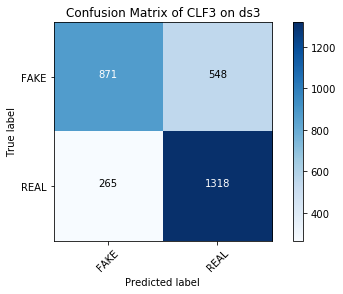

In [34]:
cm = metrics.confusion_matrix(ds3_y_test, pred_clf3_ds3, labels=['true', 'false'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'], title='Confusion Matrix of CLF3 on ds3')

### Export to rdf

couldn't find a schema

In [35]:
from rdflib import Namespace, Graph, Literal
from rdflib.namespace import FOAF, OWL, XSD, RDFS, DCTERMS, DOAP, DC


prov = Namespace('http://www.w3.org/ns/prov#')
dcat = Namespace('http://www.w3.org/ns/dcat#')
mexalgo = Namespace('http://mex.aksw.org/mex-algo#')
mexperf = Namespace('http://mex.aksw.org/mex-perf#')
mexcore = Namespace('http://mex.aksw.org/mex-core#')
this = Namespace('http://mex.aksw.org/examples/')


In [36]:
g = Graph()
# Create Binding
g.bind('dct',DCTERMS)
g.bind('owl',OWL)
g.bind('foaf',FOAF)
g.bind('xsd', XSD)
g.bind('rdfs', RDFS)
g.bind('doap', DOAP)
g.bind('dc', DC)
g.bind('prov', prov)
g.bind('dcat', dcat)
g.bind('mexalgo',mexalgo)
g.bind('mexperf',mexperf)
g.bind('mexcore',mexcore)
g.bind('this',this)

In [37]:
g.add((this.nlp_ex2_nilutz,mexcore.Experiment, prov.Entity))
g.add((this.nlp_ex2_nilutz,mexcore.ApplicationContext, prov.Entity))
#g.add((this.nlp_ex2_nilutz,RDFS.label, Literal('2255383')))
g.add((this.nlp_ex2_nilutz,DCTERMS.date, Literal('2018-05-20',datatype=XSD.date)))
g.add((this.nlp_ex2_nilutz,FOAF.givenName, Literal('Nico')))

#Configuration-1
g.add((this.configuration1,mexcore.ExperimentConfiguration, prov.Entity))
g.add((this.configuration1,prov.used, this.model1))
g.add((this.configuration1,prov.wasStartedBy, this.nlp_ex2_nilutz))

#Configuration-2
g.add((this.configuration2,mexcore.ExperimentConfiguration, prov.Entity))
g.add((this.configuration2,prov.used, this.model2))
g.add((this.configuration2,prov.wasStartedBy, this.nlp_ex2_nilutz))

#Configuration-3
g.add((this.configuration3,mexcore.ExperimentConfiguration, prov.Entity))
g.add((this.configuration3,prov.used, this.model2))
g.add((this.configuration3,prov.used, this.model1))
g.add((this.configuration3,prov.wasStartedBy, this.nlp_ex2_nilutz))

#Configuration-4
g.add((this.configuration4,mexcore.ExperimentConfiguration, prov.Entity))
g.add((this.configuration4,prov.used, this.model4))
g.add((this.configuration4,prov.wasStartedBy, this.nlp_ex2_nilutz))

g.add((this.test,mexcore.Test,prov.Entity))
g.add((this.test,RDFS.label,Literal('Test')))

g.add((this.hyerparameter_model1,mexalgo.HyperParameterCollection,prov.Entity))
g.add((this.hyerparameter1,RDFS.label,Literal('HyperParameterCollection')))
g.add((this.hyerparameter_model1,prov.hadMember,this.hyerparameter1))

g.add((this.hyerparameter1,mexalgo.HyperParameter,prov.Entity))
g.add((this.hyerparameter1,RDFS.label, Literal('alpha')))
g.add((this.hyerparameter1,DCTERMS.identifier, Literal('alpha')))
g.add((this.hyerparameter1,prov.value, Literal('0.05',datatype=XSD.float)))

g.add((this.dataset1,mexcore.Dataset,prov.Entity))
g.add((this.dataset1,RDFS.label,Literal('Fake-News')))
g.add((this.dataset1,DCTERMS.landingPage,Literal('https://github.com/GeorgeMcIntire/fake_real_news_dataset')))

g.add((this.dataset2,mexcore.Dataset,prov.Entity))
g.add((this.dataset2,RDFS.label,Literal('Liar-Liar')))
g.add((this.dataset2,DCTERMS.landingPage,Literal('https://www.cs.ucsb.edu/william/data/liar_dataset.zip')))

g.add((this.dataset3,mexcore.Dataset,prov.Entity))
g.add((this.dataset3,RDFS.label,Literal('Fake-News+Liar-Liar')))
g.add((this.dataset3,DCTERMS.landingPage,Literal('https://www.cs.ucsb.edu/william/data/liar_dataset.zip')))
g.add((this.dataset3,DCTERMS.landingPage,Literal('https://github.com/GeorgeMcIntire/fake_real_news_dataset')))

g.add((this.cross_validation,mexcore.crossValidation,prov.Entity))
g.add((this.cross_validation,RDFS.label,Literal('cross validation')))
g.add((this.cross_validation,mexcore.folds,Literal('5',datatype=XSD.integer)))
g.add((this.cross_validation,mexcore.random_state,Literal('4222',datatype=XSD.integer)))

g.add((this.execution1,mexcore.ExecutionOverall,prov.Entity))
g.add((this.execution1,prov.generated,this.performance_measures1))
g.add((this.execution1,prov.used,this.test))
g.add((this.execution1,prov.used,this.hyerparameter_model1))
g.add((this.execution1,prov.used,this.model1))

g.add((this.execution2,mexcore.ExecutionOverall,prov.Entity))
g.add((this.execution2,prov.generated,this.performance_measures2))
g.add((this.execution2,prov.used,this.test))
g.add((this.execution2,prov.used,this.model2))

g.add((this.execution3,mexcore.ExecutionOverall,prov.Entity))
g.add((this.execution3,prov.generated,this.performance_measures3))
g.add((this.execution3,prov.used,this.test))
g.add((this.execution3,prov.used,this.model2))
g.add((this.execution3,prov.used,this.model3))

g.add((this.execution4,mexcore.ExecutionOverall,prov.Entity))
g.add((this.execution4,prov.generated,this.performance_measures4))
g.add((this.execution4,prov.used,this.test))
g.add((this.execution4,prov.used,this.model4))

g.add((this.performance_measures1,mexcore.PerformanceMeasure,prov.Entity))
g.add((this.performance_measures1,mexperf.precision,Literal(conf_1p[0][0],datatype=XSD.float)))
g.add((this.performance_measures1,mexperf.recall,Literal(conf_1p[0][1],datatype=XSD.float)))
g.add((this.performance_measures1,mexperf.accuracy,Literal(conf_1p[0][2],datatype=XSD.float)))
g.add((this.performance_measures1,prov.wasGeneratedBy,this.execution1))

g.add((this.performance_measures2,mexcore.PerformanceMeasure,prov.Entity))
g.add((this.performance_measures2,mexperf.precision,Literal(conf2_p[0],datatype=XSD.float)))
g.add((this.performance_measures2,mexperf.recall,Literal(conf2_p[1],datatype=XSD.float)))
g.add((this.performance_measures2,mexperf.accuracy,Literal(conf2_p[2],datatype=XSD.float)))
g.add((this.performance_measures2,prov.wasGeneratedBy,this.execution2))

g.add((this.performance_measures3,mexcore.PerformanceMeasure,prov.Entity))
g.add((this.performance_measures3,mexperf.precision,Literal(conf3_21[0],datatype=XSD.float)))
g.add((this.performance_measures3,mexperf.recall,Literal(conf3_21[1],datatype=XSD.float)))
g.add((this.performance_measures3,mexperf.accuracy,Literal(conf3_21[2],datatype=XSD.float)))
g.add((this.performance_measures3,prov.wasGeneratedBy,this.execution3))

g.add((this.performance_measures4,mexcore.PerformanceMeasure,prov.Entity))
g.add((this.performance_measures4,mexperf.precision,Literal(conf4[0],datatype=XSD.float)))
g.add((this.performance_measures4,mexperf.recall,Literal(conf4[1],datatype=XSD.float)))
g.add((this.performance_measures4,mexperf.accuracy,Literal(conf4[2],datatype=XSD.float)))
g.add((this.performance_measures4,prov.wasGeneratedBy,this.execution4))


g.add((this.model1,mexalgo.Algorithm,prov.Entity))
g.add((this.model1,RDFS.label,Literal('MultinomialNB')))
g.add((this.model1,DCTERMS.identifier,Literal('MultinomialNB')))
g.add((this.model1,mexalgo.hasHyperParameter,this.hyerparameter1))

g.add((this.model2,mexalgo.Algorithm,prov.Entity))
g.add((this.model2,RDFS.label,Literal('OneVsRestClassifier')))
g.add((this.model2,DCTERMS.identifier,Literal('OneVsRestClassifier')))

g.add((this.model4,mexalgo.Algorithm,prov.Entity))
g.add((this.model4,RDFS.label,Literal('RandomForestClassifier')))
g.add((this.model4,DCTERMS.identifier,Literal('RandomForestClassifier')))

with open('nico_lutz_meta_ex2.ttl','wb') as f:
    f.write(g.serialize(format='turtle'))